# VIGIA Competition Notebook

This notebook is a conversion of the `vigia-competition.py` script. Each section of the original script is split into one or more cells.

In [19]:
import pandas as pd, numpy as np, tensorflow as tf
from sklearn.model_selection import StratifiedKFold, train_test_split  # CV splitter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

In [20]:
IMG_SIZE     = (32, 32)        # input resolution in your CNN
BATCH_SIZE   = 64
EPOCHS       = 15
N_SPLITS     = 5               # k-fold
SEED         = 42

TRAIN_DIR    = "archive/train/train/"   # path with labelled jpg
TEST_DIR     = "archive/train/train/"     # modified: use training directory since no true test labels
TRAIN_CSV    = "archive/train.csv"


In [21]:
train_df = pd.read_csv(TRAIN_CSV)
print("Training samples:", len(train_df))

# Split the full training set into CV and hold-out test sets (both from TRAIN_DIR)
train_cv_df, holdout_df = train_test_split(train_df, test_size=0.2, stratify=train_df['has_cactus'], random_state=SEED)
print("Train CV samples:", len(train_cv_df))
print("Holdout Test samples:", len(holdout_df))

Training samples: 17500
Train CV samples: 14000
Holdout Test samples: 3500


## Helper: Build a Fresh Model for Each Fold

The following function creates a new CNN model to be used in every fold of cross validation.

In [22]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=IMG_SIZE + (3,)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Cross-Validation Loop

The following cell performs k-fold cross validation. For each fold, it splits the data, creates data generators, builds & trains the model, and makes predictions on the test set.

In [23]:
# Use the train_cv_df for k-fold cross validation
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
histories = []
val_scores = []
test_pred_table = []  # will store predictions on the validation fold per CV

for fold, (tr_idx, val_idx) in enumerate(skf.split(train_cv_df['id'], train_cv_df['has_cactus'])):
    print(f"\n──────────  Fold {fold+1}/{N_SPLITS}  ──────────")
    tr_fold_df  = train_cv_df.iloc[tr_idx].reset_index(drop=True)
    val_fold_df = train_cv_df.iloc[val_idx].reset_index(drop=True)

    # Convert target column to string for binary classification if needed
    tr_fold_df['has_cactus'] = tr_fold_df['has_cactus'].astype(str)
    val_fold_df['has_cactus'] = val_fold_df['has_cactus'].astype(str)

    tr_gen = tr_datagen.flow_from_dataframe(
        tr_fold_df, TRAIN_DIR,
        x_col='id', y_col='has_cactus',
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='binary', shuffle=True, seed=SEED
    )
    val_gen = val_datagen.flow_from_dataframe(
        val_fold_df, TRAIN_DIR,
        x_col='id', y_col='has_cactus',
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='binary', shuffle=False
    )

    model = build_model()
    es = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')
    hist = model.fit(
        tr_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[es],
        verbose=1
    )
    histories.append(hist)
    val_acc = hist.history['val_accuracy'][-1]
    val_scores.append(val_acc)
    print(f"Fold-{fold+1} final val-accuracy: {val_acc:.4f}")
    test_pred_table.append(hist.history['val_accuracy'][-1])


──────────  Fold 1/5  ──────────
Found 11200 validated image filenames belonging to 2 classes.
Found 2800 validated image filenames belonging to 2 classes.
Found 2800 validated image filenames belonging to 2 classes.
Epoch 1/15
Epoch 1/15


/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.7903 - loss: 0.4411 - val_accuracy: 0.9375 - val_loss: 0.1829
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.7903 - loss: 0.4411 - val_accuracy: 0.9375 - val_loss: 0.1829
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9238 - loss: 0.2096 - val_accuracy: 0.9286 - val_loss: 0.1876
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9238 - loss: 0.2096 - val_accuracy: 0.9286 - val_loss: 0.1876
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9375 - loss: 0.1730 - val_accuracy: 0.9264 - val_loss: 0.2034
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9375 - loss: 0.1730 - val_accuracy: 0.9264 - val_loss: 0.2034
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9413 - loss: 0.1553 - val_accuracy: 0.9450 - val_loss: 0.1416
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9413 - loss: 0.1553 - val_accuracy: 0.945

/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8125 - loss: 0.4043 - val_accuracy: 0.9279 - val_loss: 0.2021
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8125 - loss: 0.4043 - val_accuracy: 0.9279 - val_loss: 0.2021
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9222 - loss: 0.2120 - val_accuracy: 0.9100 - val_loss: 0.2297
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9222 - loss: 0.2120 - val_accuracy: 0.9100 - val_loss: 0.2297
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9433 - loss: 0.1657 - val_accuracy: 0.9582 - val_loss: 0.1148
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9433 - loss: 0.1657 - val_accuracy: 0.9582 - val_loss: 0.1148
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9460 - loss: 0.1479 - val_accuracy: 0.9611 - val_loss: 0.1146
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9460 - loss: 0.1479 - val_accuracy: 0.961

/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8330 - loss: 0.3720 - val_accuracy: 0.9411 - val_loss: 0.1619
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8330 - loss: 0.3720 - val_accuracy: 0.9411 - val_loss: 0.1619
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9264 - loss: 0.2055 - val_accuracy: 0.9543 - val_loss: 0.1238
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9264 - loss: 0.2055 - val_accuracy: 0.9543 - val_loss: 0.1238
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9433 - loss: 0.1661 - val_accuracy: 0.9364 - val_loss: 0.1656
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9433 - loss: 0.1661 - val_accuracy: 0.9364 - val_loss: 0.1656
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9490 - loss: 0.1438 - val_accuracy: 0.9639 - val_loss: 0.1016
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9490 - loss: 0.1438 - val_accuracy: 0.963

/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8339 - loss: 0.3728 - val_accuracy: 0.9218 - val_loss: 0.2335
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8339 - loss: 0.3728 - val_accuracy: 0.9218 - val_loss: 0.2335
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9195 - loss: 0.2117 - val_accuracy: 0.9532 - val_loss: 0.1376
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9195 - loss: 0.2117 - val_accuracy: 0.9532 - val_loss: 0.1376
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9301 - loss: 0.1861 - val_accuracy: 0.9400 - val_loss: 0.1737
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9301 - loss: 0.1861 - val_accuracy: 0.9400 - val_loss: 0.1737
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9440 - loss: 0.1598 - val_accuracy: 0.9511 - val_loss: 0.1363
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9440 - loss: 0.1598 - val_accuracy: 0.951

/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8162 - loss: 0.3970 - val_accuracy: 0.9279 - val_loss: 0.2121
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8162 - loss: 0.3970 - val_accuracy: 0.9279 - val_loss: 0.2121
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9281 - loss: 0.2071 - val_accuracy: 0.9454 - val_loss: 0.1465
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9281 - loss: 0.2071 - val_accuracy: 0.9454 - val_loss: 0.1465
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9314 - loss: 0.1920 - val_accuracy: 0.9236 - val_loss: 0.2179
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9314 - loss: 0.1920 - val_accuracy: 0.9236 - val_loss: 0.2179
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9394 - loss: 0.1633 - val_accuracy: 0.9200 - val_loss: 0.2305
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9394 - loss: 0.1633 - val_accuracy: 0.920

In [25]:
# Create a generator for the hold-out test set from the same TRAIN_DIR
holdout_df['has_cactus'] = holdout_df['has_cactus'].astype(str)
holdout_gen = test_datagen.flow_from_dataframe(
    dataframe=holdout_df,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='has_cactus',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Evaluate the final model on the hold-out test set (using the last model trained in CV, for example)
holdout_eval = model.evaluate(holdout_gen, verbose=1)
print("Holdout Test Loss/Accuracy:", holdout_eval)

Found 3500 validated image filenames belonging to 2 classes.
 5/55 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9663 - loss: 0.0684

/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9798 - loss: 0.0598
Holdout Test Loss/Accuracy: [0.06399578601121902, 0.9797142744064331]
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9798 - loss: 0.0598
Holdout Test Loss/Accuracy: [0.06399578601121902, 0.9797142744064331]


In [27]:
print("\nCV accuracy per fold:", np.round(val_scores, 4))
print(f"Mean ± SD accuracy  : {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}")

# Ensemble (mean) of probabilities from all folds
test_mean_prob = np.mean(np.stack(test_pred_table, axis=0), axis=0)
test_labels    = (test_mean_prob > 0.5).astype(int)

submission = pd.DataFrame({
    "id": [Path(p).name for p in sorted(Path(TEST_DIR).glob("*.jpg"))],
    "has_cactus": test_labels
})
submission.to_csv("submission_kfold.csv", index=False)
print("✔ submission_kfold.csv saved")


CV accuracy per fold: [0.9289 0.9829 0.9582 0.9625 0.9725]
Mean ± SD accuracy  : 0.9610 ± 0.0182
✔ submission_kfold.csv saved


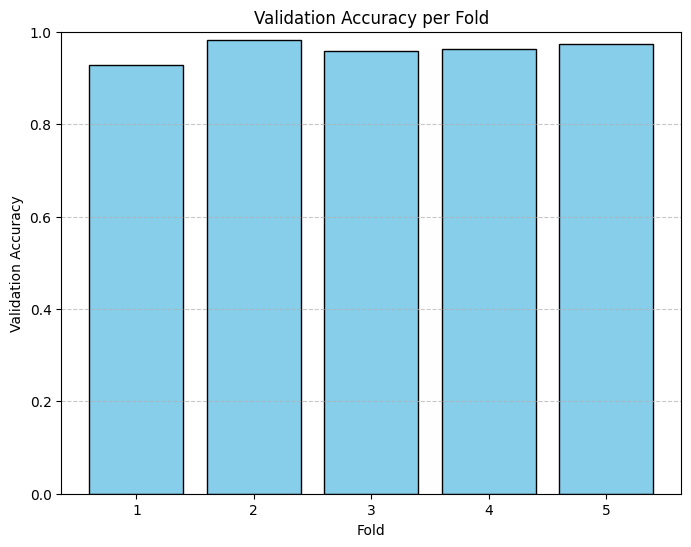

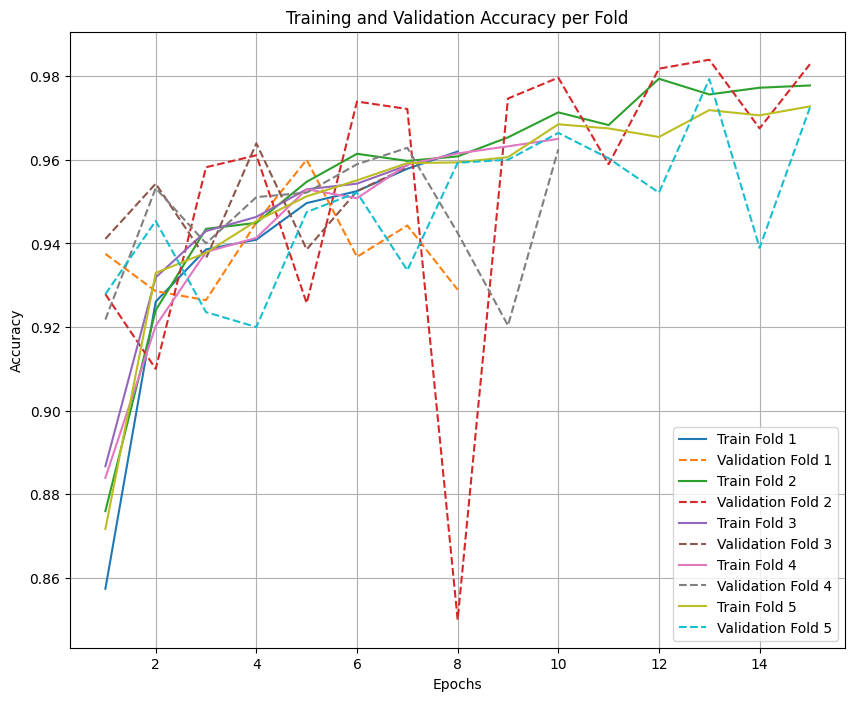

In [28]:
# Evaluate and visualize performance across the k-folds
fold_indices = list(range(1, N_SPLITS+1))  # e.g., [1, 2, 3, 4, 5]

plt.figure(figsize=(8,6))
plt.bar(fold_indices, val_scores, color='skyblue', edgecolor='black')
plt.title("Validation Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Validation Accuracy")
plt.xticks(fold_indices)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Additionally, visualize training and validation accuracy curves for each fold
plt.figure(figsize=(10,8))
for i, hist in enumerate(histories):
    epochs = range(1, len(hist.history['accuracy']) + 1)
    plt.plot(epochs, hist.history['accuracy'], label=f'Train Fold {i+1}')
    plt.plot(epochs, hist.history['val_accuracy'], label=f'Validation Fold {i+1}', linestyle='--')
plt.title("Training and Validation Accuracy per Fold")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Compute evaluation metrics on the hold-out test set
# Assuming true labels are provided by holdout_gen.classes
y_true = holdout_gen.classes
y_pred_prob = model.predict(holdout_gen).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_prob)
cm = confusion_matrix(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Precision: 0.9841
Recall: 0.9890
F1-score: 0.9865
AUC-ROC: 0.9971
Confusion Matrix:
[[ 831   42]
 [  29 2598]]
Precision: 0.9841
Recall: 0.9890
F1-score: 0.9865
AUC-ROC: 0.9971
Confusion Matrix:
[[ 831   42]
 [  29 2598]]
